#### Main Force

In [4]:
import pandas as pd
import numpy as np
import os

In [9]:
data_path = '../data'
close_data = pd.read_pickle(os.path.join(data_path, 'close_data_minute.pkl'))
volume_data = pd.read_pickle(os.path.join(data_path, 'volume_data_minute.pkl'))

close_data.ffill(inplace=True)
volume_data.ffill(inplace=True)

In [10]:
def categorize_level(data):
  '''
  data can be close_data or volume_data
  previous minute close < current minute close = 'H', on close_data: 上涨; on volume_data: 放量
  previous minute close > current minute close = 'L', on close_data: 下跌; on volume_data: 缩量
  '''
  output_data = pd.DataFrame(index=data.index, columns=data.columns)

  for i in range(1, data.shape[0]):
    output_data.iloc[i] = np.where(data.iloc[i] > data.iloc[i-1], 'H', 'L')

  return output_data

def categorize_status_method_one(close_data, volume_data):
  '''
  categorisation method one:
  1. HH: 放量上涨
  2. HL: 放量下跌
  3. LH: 缩量上涨
  4. LL: 缩量下跌
  '''
  # group by day because operation is done within the same day
  volume_data_status = volume_data.groupby(pd.Grouper(freq='D')).apply(lambda x: categorize_level(x))
  close_data_status = close_data.groupby(pd.Grouper(freq='D')).apply(lambda x: categorize_level(x))

  # ungroup
  volume_data_status = volume_data_status.reset_index(level=0).drop('DateTime', axis=1)
  close_data_status = close_data_status.reset_index(level=0).drop('DateTime', axis=1)

  # concatenate string labels
  combined_status = volume_data_status + close_data_status
  combined_status.dropna(inplace=True)
  return combined_status

In [11]:
# step1: categorise based on method one
categorised_data_method_one = categorize_status_method_one(close_data, volume_data)

In [32]:
# 放量上涨 and 放量下跌
# filtered_data = categorised_data_method_one[(categorised_data_method_one == 'HH') | (categorised_data_method_one == 'LL')]
filtered_data = categorised_data_method_one[(categorised_data_method_one == 'HH')]

# step2: the corresponding returns from return_data_intraday
return_data_intraday = close_data.pct_change()
corresponding_returns = return_data_intraday[filtered_data.notna()]
corresponding_returns.fillna(0, inplace=True)

In [33]:
# cumulative product for each day, using intraday returns
# originally shoud be lambda x: (x+1).product() - 1, for daily return, this does not perform as well as the following
return_daily_on_LL_HH = corresponding_returns.groupby(pd.Grouper(freq='D')).apply(lambda x: (x+1).product() - 1)

In [34]:
# Step 3: 对过去20 个日度收益率先做截面标准化，取其绝对值，再做截面标准化
# 然后计算绝对值调整后的过去20日收益率的标准差。

def calculate_standardized_returns(dataset):
  rolling_window = dataset.rolling('20D')
  standardized_returns = (dataset - rolling_window.mean()) / rolling_window.std()
  standardized_returns.fillna(0, inplace=True)
  return standardized_returns

# calculate standardized returns
standardized_returns = calculate_standardized_returns(return_daily_on_LL_HH)

# Take the absolute value of the standardized returns
abs_standardized_returns = standardized_returns.abs()

# Standardize the absolute values again
abs_standardized_returns = calculate_standardized_returns(abs_standardized_returns)

# Calculate the standard deviation of the adjusted returns
std_adjusted_returns = abs_standardized_returns.rolling('20D').std()

In [35]:
std_adjusted_returns.to_pickle('../factor_outputs/HH_vol_factor.pkl')

### Analysis

In [36]:
std_adjusted_returns = std_adjusted_returns.iloc[2:]

the factor's ic is -0.005518174997334035
the factor's ir is -0.057169472367005904




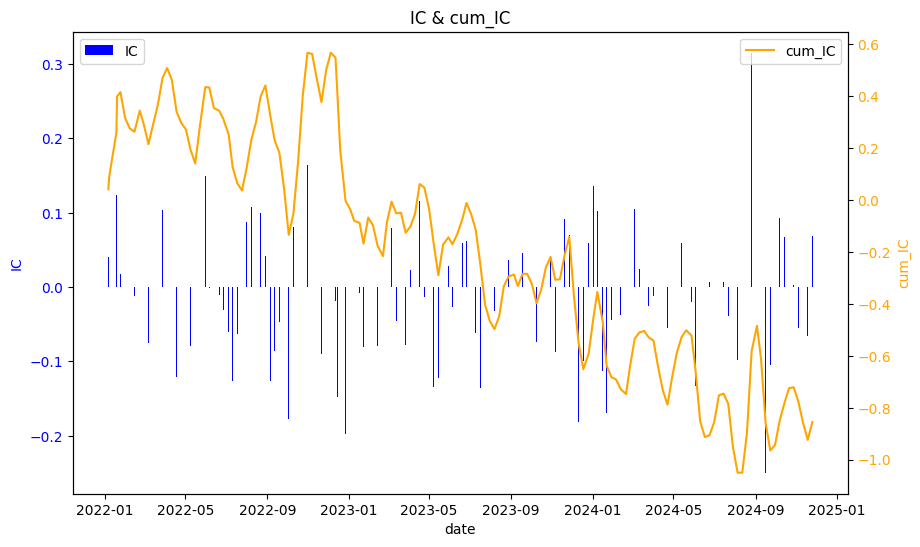

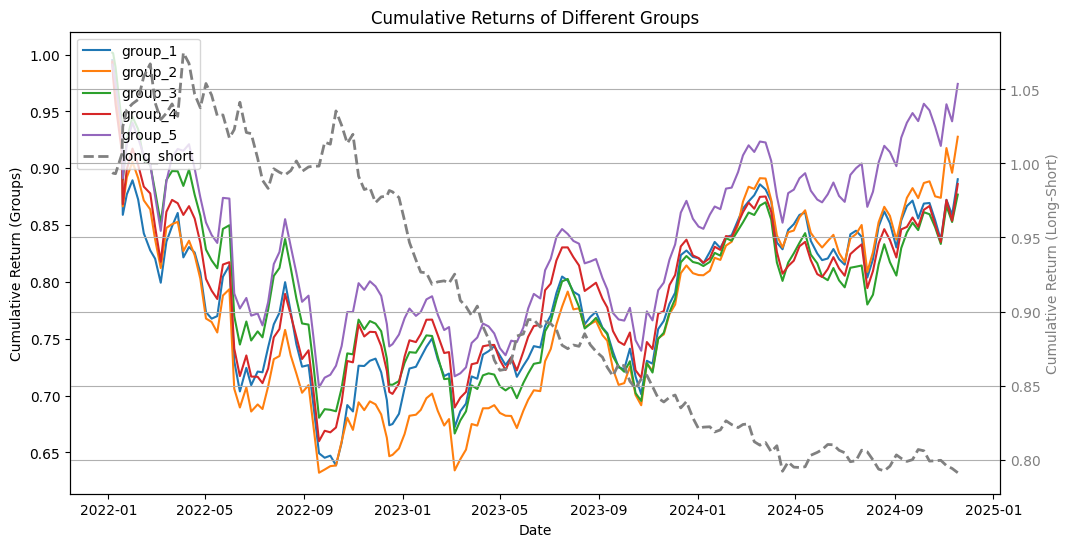


=== Backtesting statistical metrics ===
transaction_cost: 0.10%(single side)
Annualized return:
group_1      -0.1102
group_2      -0.0477
group_3      -0.1441
group_4      -0.1253
group_5       0.0218
long_short   -0.3719
dtype: float64

Annualized volatility:
group_1       0.3981
group_2       0.3857
group_3       0.3756
group_4       0.3804
group_5       0.3589
long_short    0.1501
dtype: float64

Sharpe ratio:
group_1      -0.2768
group_2      -0.1237
group_3      -0.3837
group_4      -0.3294
group_5       0.0607
long_short   -2.4777
dtype: float64

max drawback:
group_1      -0.3583
group_2      -0.3631
group_3      -0.3345
group_4      -0.3360
group_5      -0.2864
long_short   -0.2639
dtype: float64


group_1   group_2   group_3   group_4   group_5  long_short
2022-01-06  0.995246  0.992575  1.001654  0.993836  0.991116    0.993870
2022-01-07  0.990465  0.986374  1.001267  0.979994  0.987898    0.993430
2022-01-10  0.974980  0.971755  0.989023  0.956565  0.974092    0.993090
2022-01-18  0.919592  0.914622  0.938592  0.913720  0.933944    1.006590
2022-01-19  0.859031  0.866447  0.889949  0.868405  0.891354    1.024964
...              ...       ...       ...       ...       ...         ...
2024-10-21  0.854345  0.875281  0.848104  0.850308  0.936597    0.799188
2024-10-28  0.836826  0.874014  0.833399  0.835166  0.919649    0.799517
2024-11-04  0.872278  0.917763  0.866881  0.872102  0.956306    0.795914
2024-11-11  0.858913  0.896031  0.852733  0.853830  0.941292    0.794021
2024-11-18  0.890366  0.927727  0.876850  0.886086  0.974221    0.791135

[154 rows x 6 columns]

In [37]:
from util import *
import warnings
warnings.filterwarnings('ignore') # for clearness of the output

all_data = pd.read_pickle(os.path.join(data_path, 'all_data.pkl'))

factor_name = 'mfv'
factor_stacked = std_adjusted_returns.stack().reset_index()
factor_stacked.columns = ['Date', 'Ticker', factor_name]
factor_cleaned = factor_washing(factor_stacked, factor_name, window_len=5)

merged_data = df_factor_merge(all_data, factor_cleaned, factor_name)
cal_icir(merged_data, factor_name, trade_interval='w')
group_backtest(merged_data, factor_name, trade_interval='w', transaction_cost=0.001)

# create_factor_graphs_v2(all_data, factor_cleaned, '1', trade_interval='w', transaction_cost=0.001)

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1                0.000000  0.982299  0.702015  0.109280  52850  10.070158
2                0.362610  1.037655  0.828296  0.083052  52754  10.051866
3                0.387954  1.088350  0.890191  0.079963  51832   9.876186
4                0.415928  1.131140  0.937748  0.078244  52811  10.062727
5                0.439418  1.172329  0.979176  0.076205  52531  10.009375
6                0.455515  1.206627  1.017898  0.074534  52055   9.918677
7                0.468452  1.241470  1.057081  0.073081  52549  10.012804
8                0.475241  1.277549  1.098816  0.071623  52094   9.926108
9                0.479676  1.322601  1.149552  0.070621  52492  10.001944
10               0.498852  1.697251  1.241786  0.084185  52850  10.070158

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.033  0.017  0.008
beta                                           0.009  0.002  0.004
Mean Period Wise Return Top Quantile (bps)     3.064  1.324  0.601
Mean Period Wise Return Bottom Quantile (bps) -0.745 -0.866 -0.544
Mean Period Wise Spread (bps)                  3.808  2.189  1.143

<Figure size 640x480 with 0 Axes>

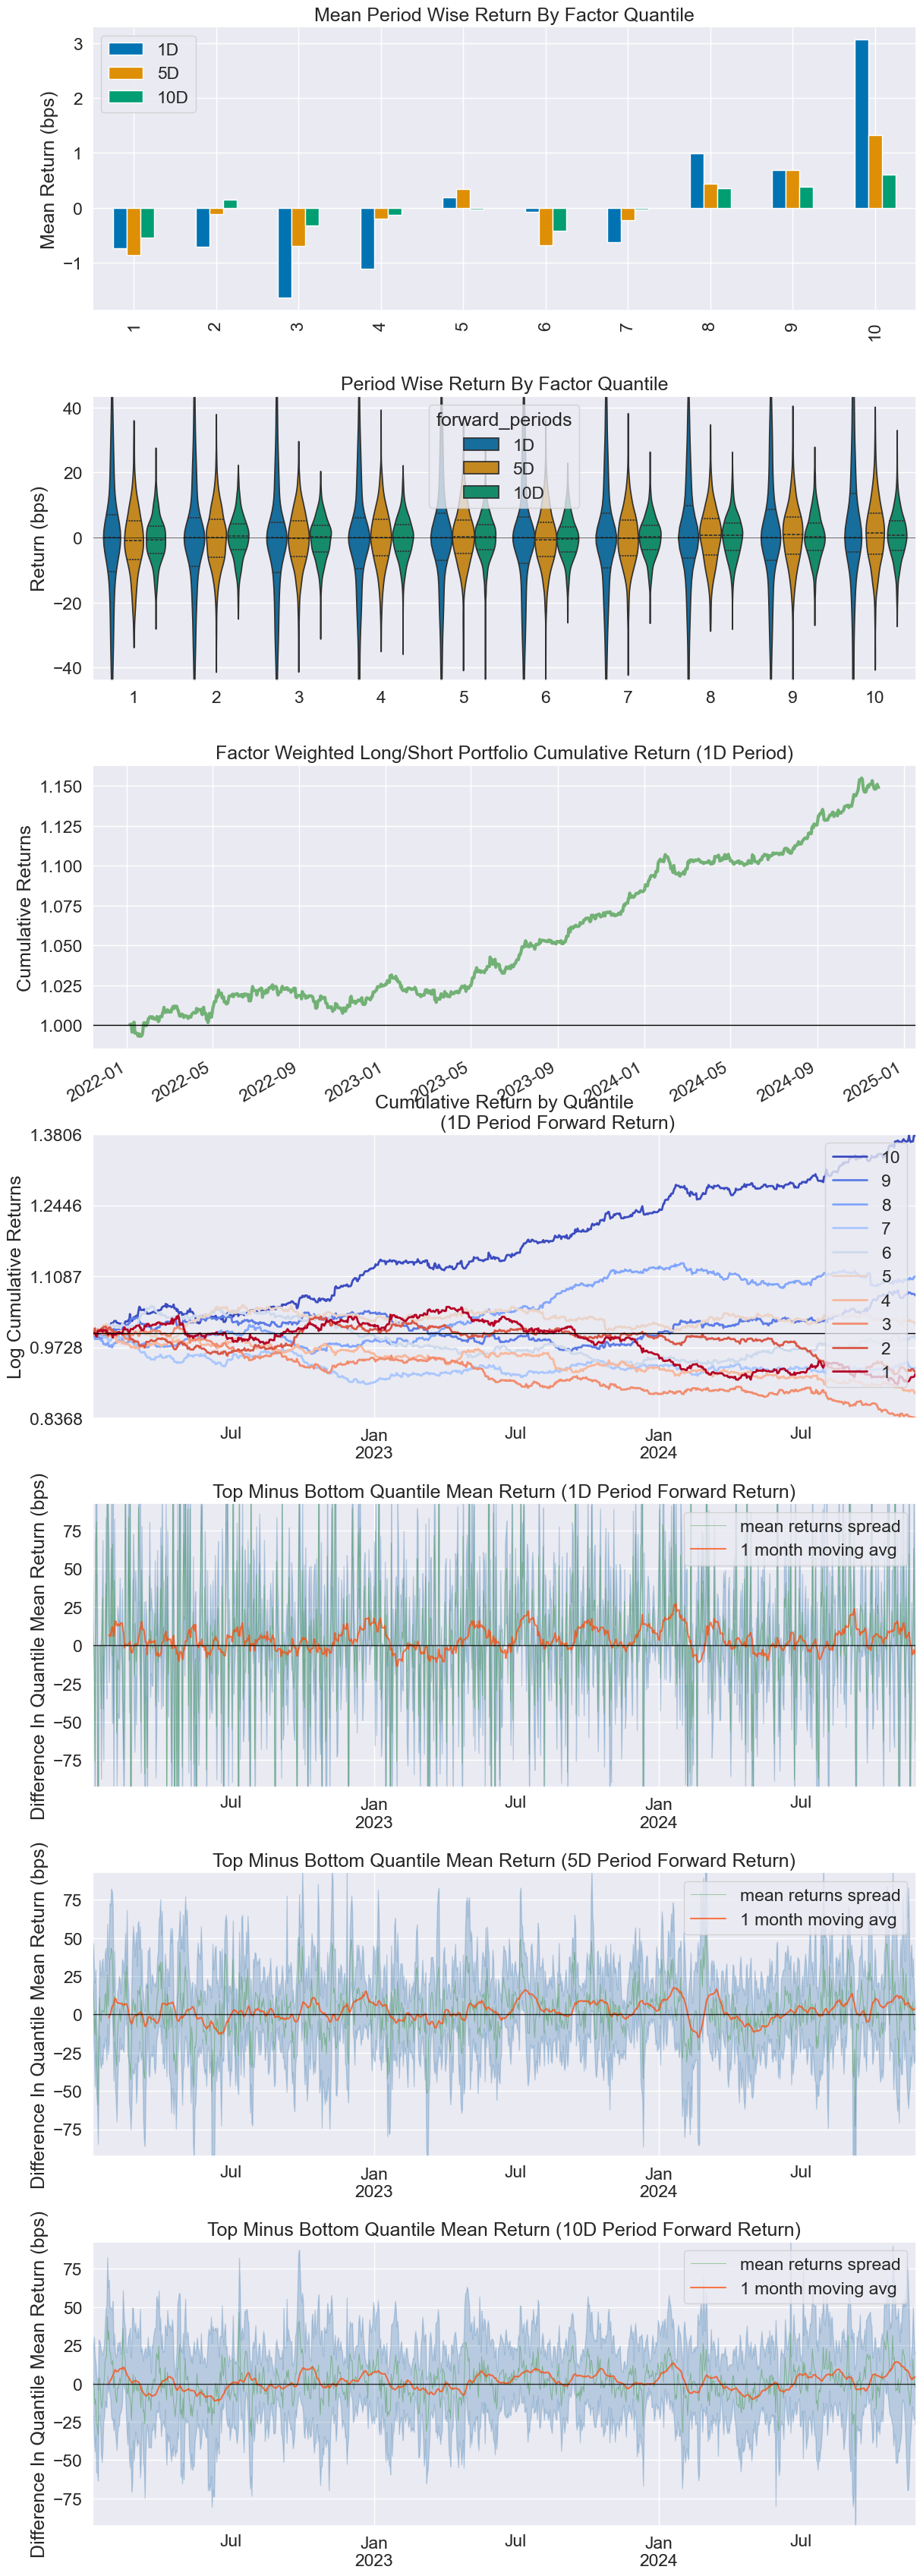

Information Analysis


1D     5D    10D
IC Mean           0.009  0.007  0.003
IC Std.           0.074  0.068  0.065
Risk-Adjusted IC  0.126  0.101  0.047
t-stat(IC)          NaN  3.277  1.512
p-value(IC)         NaN  0.001  0.131
IC Skew             NaN -0.089  0.134
IC Kurtosis         NaN  0.447  0.196

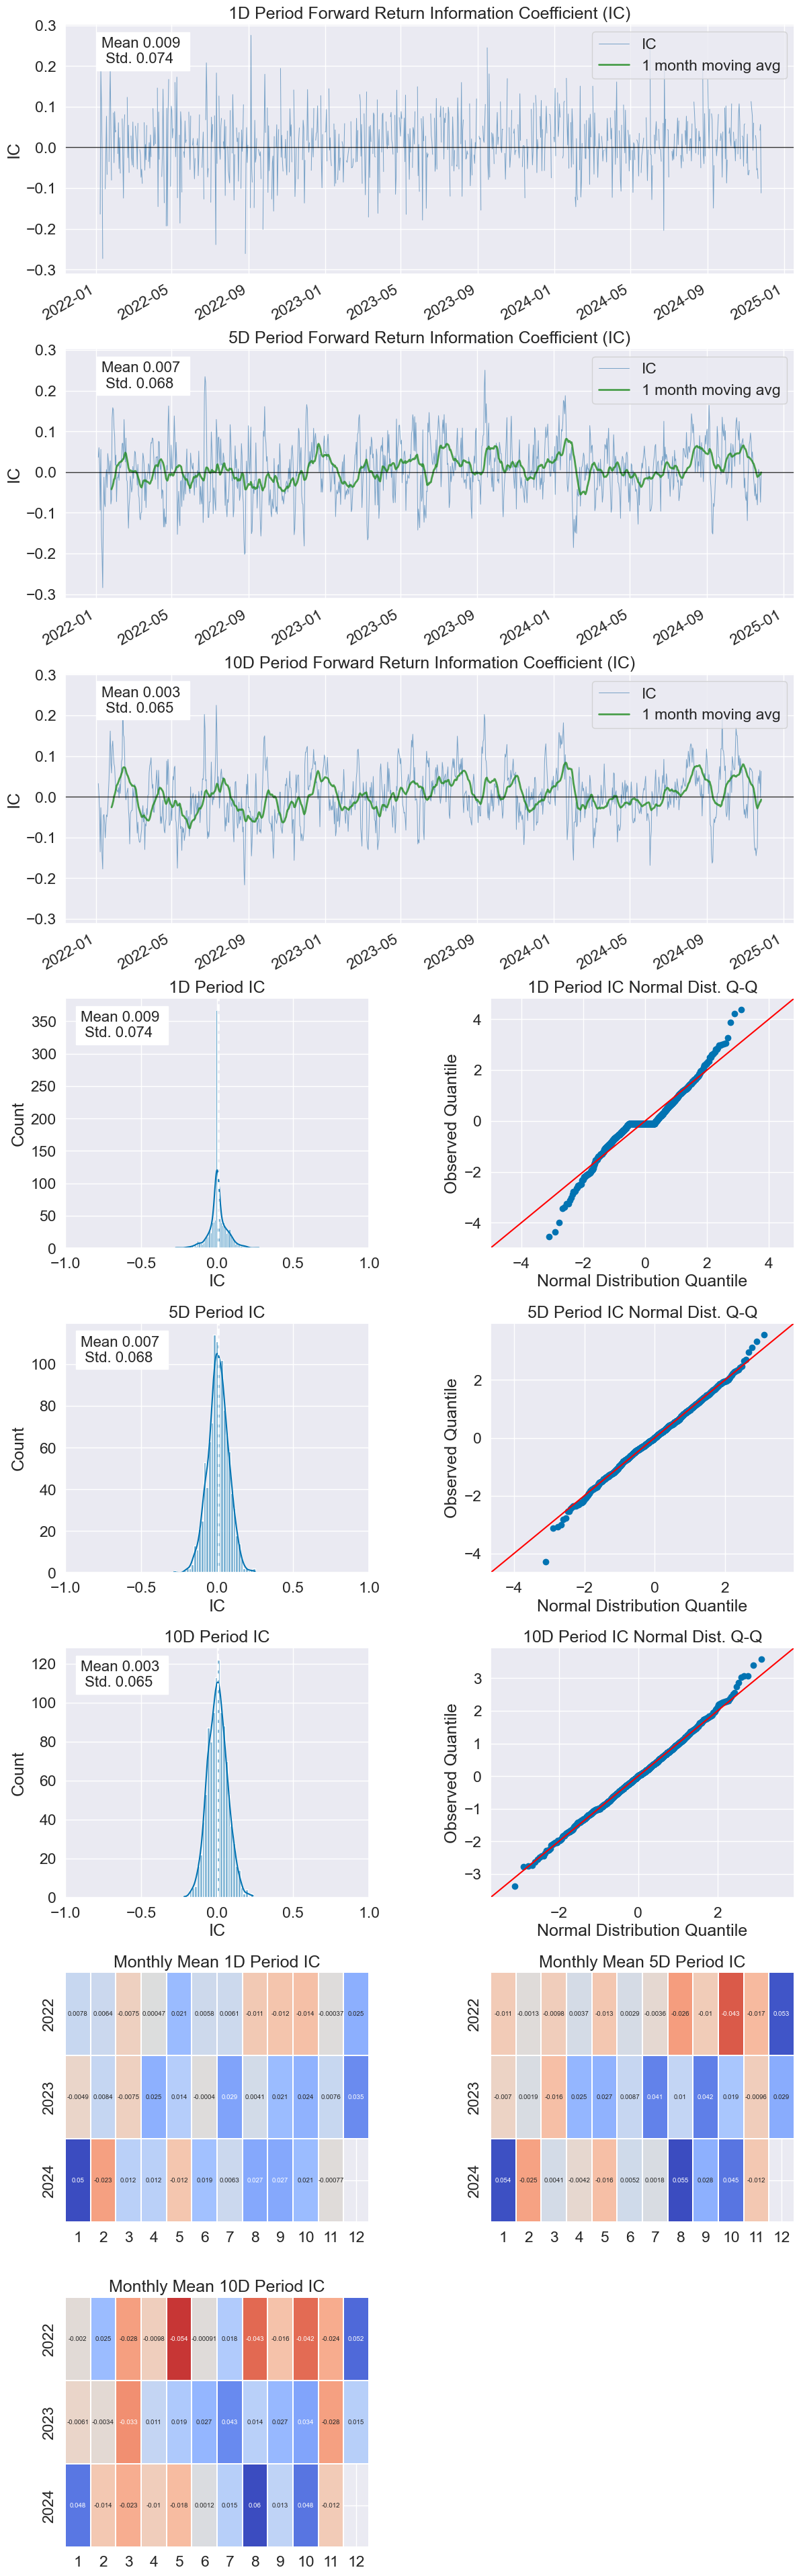

Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover    0.261  0.694  0.902
Quantile 2 Mean Turnover    0.436  0.795  0.888
Quantile 3 Mean Turnover    0.513  0.831  0.887
Quantile 4 Mean Turnover    0.539  0.840  0.888
Quantile 5 Mean Turnover    0.554  0.851  0.890
Quantile 6 Mean Turnover    0.553  0.850  0.895
Quantile 7 Mean Turnover    0.532  0.840  0.895
Quantile 8 Mean Turnover    0.489  0.819  0.892
Quantile 9 Mean Turnover    0.403  0.768  0.881
Quantile 10 Mean Turnover   0.195  0.539  0.796

1D     5D    10D
Mean Factor Rank Autocorrelation  0.908  0.527  0.081

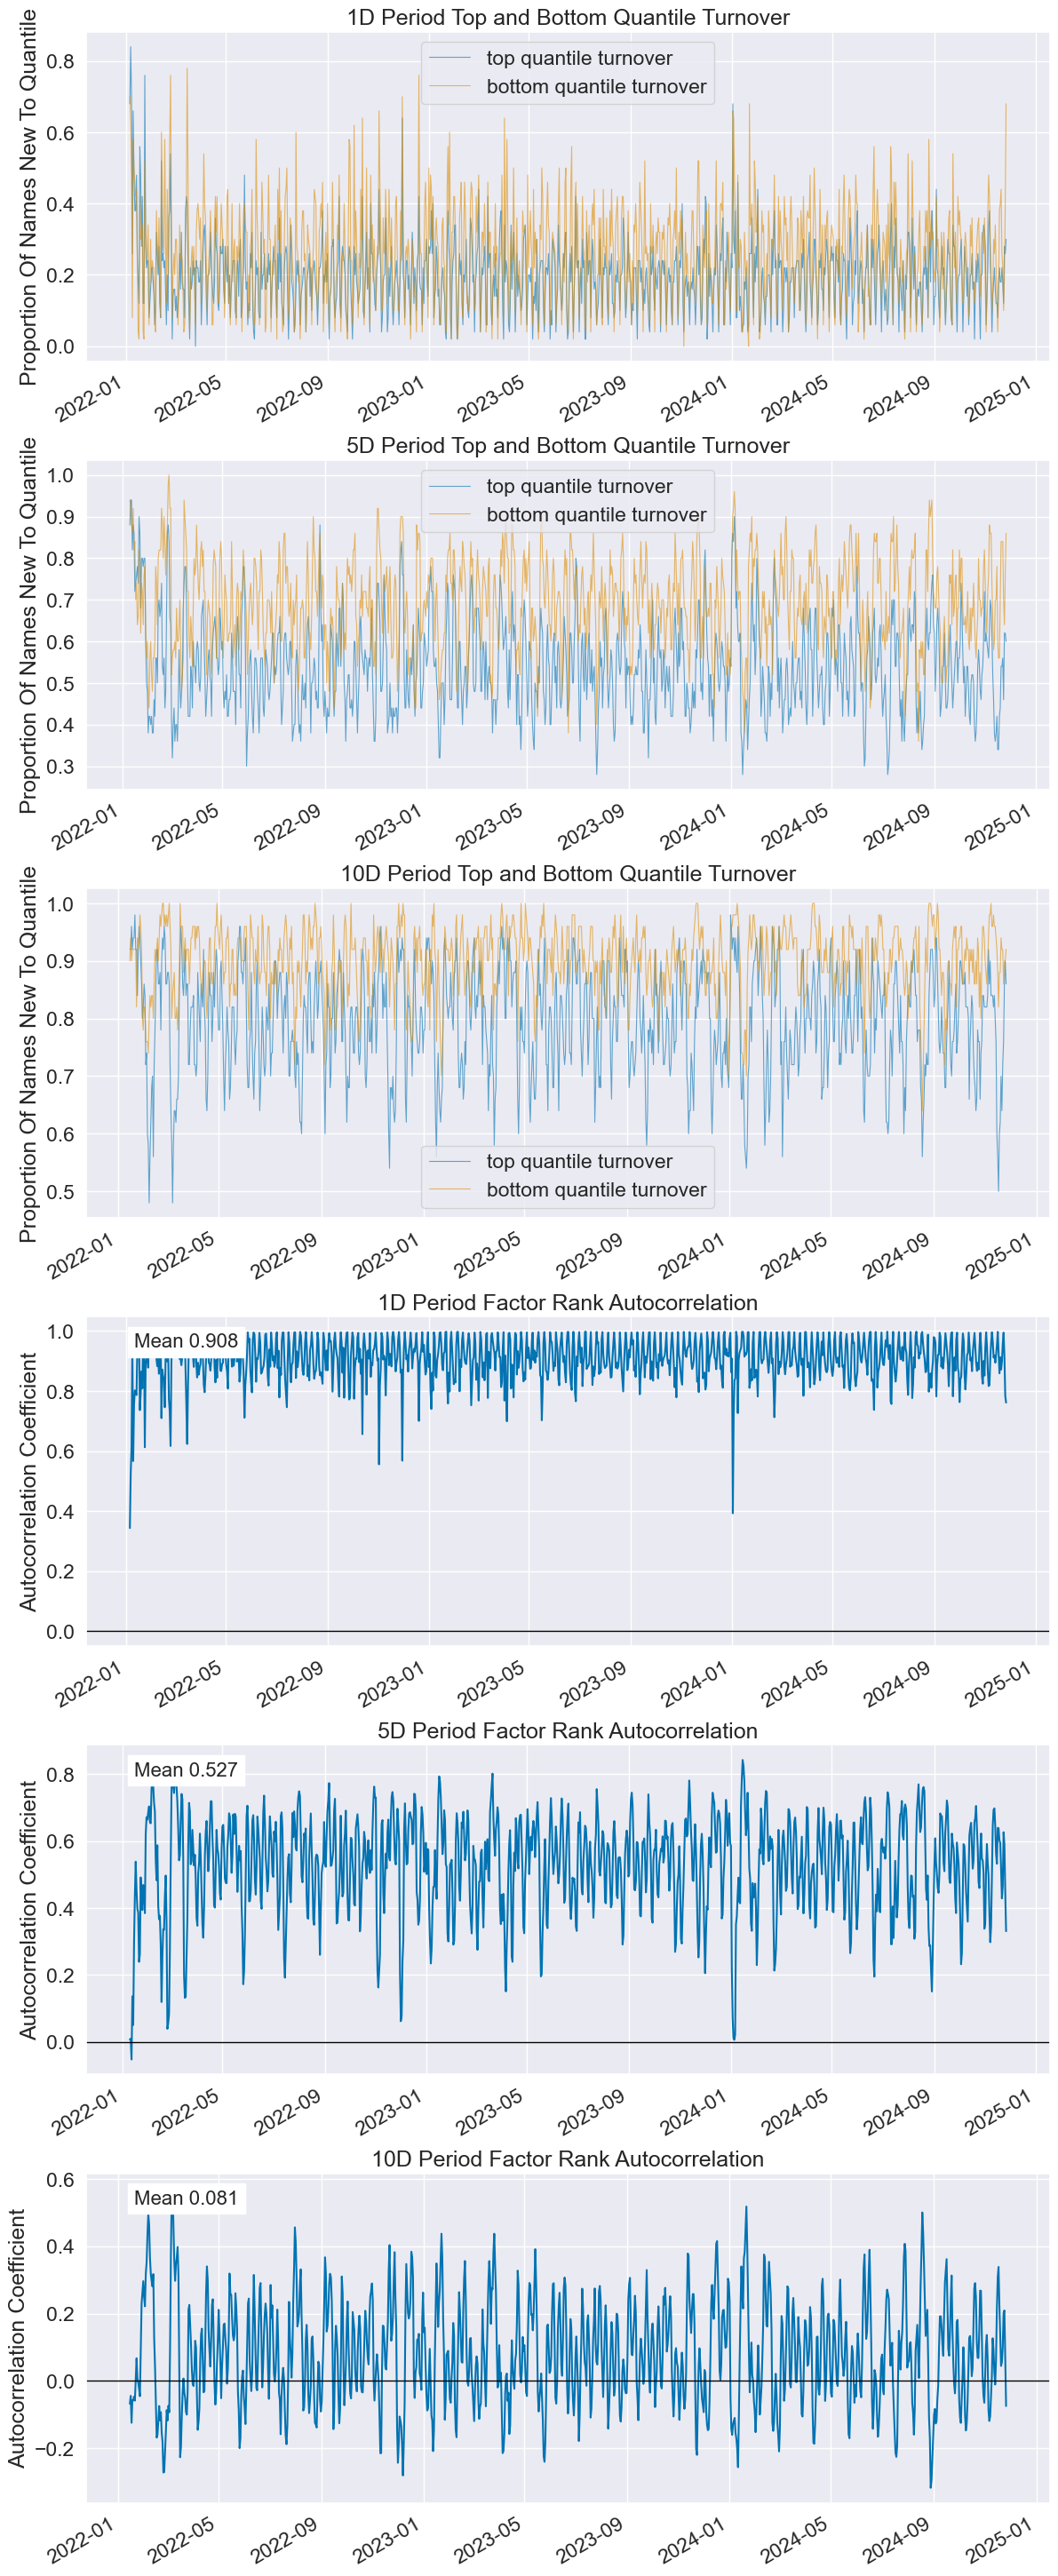

In [31]:
open_data_daily = pd.read_csv('open_data_daily.csv', index_col='DateTime', parse_dates=True)
# open_data_weekly = open_data_daily.resample('W').first()
# factor_data_weekly = std_adjusted_returns.resample('W').first()
create_factor_graphs(std_adjusted_returns, open_data_daily, quantiles=10)

Categorize method two, running time too long.

In [20]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def categorize_status_method_two(close_data, volume_data):
    '''
    Categorisation method two:
    1. HH: 放量持续上涨
    2. HL: 放量持续下跌
    3. LH: 缩量持续上涨
    4. LL: 缩量持续下跌
    5. EH: 平量持续上涨
    6. EL: 平量持续下跌
    '''

  def process_column(col, close_data, volume_data):
    diffs = close_data.diff()
    trend_categories = pd.Series(index=close_data.index, name=col)
    trend_start = 0

    for i in range(1, len(close_data)):
        # trend not in the same direction, reset start point
        if diffs[col].iloc[i] * diffs[col].iloc[i-1] < 0:
            trend_start = i
        
        if i > trend_start + 1:
            # calculate Vmax and Vmin for the current trend segment
            Vmax = volume_data[col].iloc[trend_start:i].max()
            Vmin = volume_data[col].iloc[trend_start:i].min()
            
            # categorisation on volume
            if volume_data[col].iloc[i] < Vmin:
                volume_category = '缩量'
            elif volume_data[col].iloc[i] > Vmax:
                volume_category = '放量'
            else:
                volume_category = '平量'
            
            # categorisation on trend
            if diffs[col].iloc[i] > 0:
                trend_category = '上涨'
            else:
                trend_category = '下跌'
            
            # combine the volume and trend categories
            trend_categories.iloc[i] = volume_category + trend_category
    return trend_categories
  
  # initialisation
  trend_categories = pd.DataFrame(index=close_data.index, columns=close_data.columns)

  # Use ThreadPoolExecutor to parallelize the operation for each column
  with ThreadPoolExecutor() as executor:
      futures = {executor.submit(process_column, col, close_data, volume_data): col for col in close_data.columns}
      for future in tqdm(as_completed(futures), total=len(futures), desc="Processing columns"):
          col = futures[future]
          trend_categories[col] = future.result()

  return trend_categories

IndentationError: unindent does not match any outer indentation level (<string>, line 15)